Train different deep learning models on IMDB movie review sentiment classification dataset.

- Naive Bag of Words: these simply pool the embeddings of all words in the sentence and predict using that
    - NBW-vanilla: simply train a network form scratch. Ensure that it doesn't overfit/underfit
    - NBW-pretrained
        - NBW-pretrained-static: use pretrained embeddings and don't update them
        - NBW-pretrained-finetuned: use pretrained embeddings and update them
    - visualize the embeddings
        - which words are associated with positive/negative sentiment?
        - how much of the variance in embedding space is explained by the 1-d subspace learnt by the last layer?
- BERT: train a BERT model on the dataset
    - distillBERT-pretrained-static: use pretrained BERT embeddings and don't update them
        - distillBERT-CLS-pretrained-static: use only the CLS token embedding output
        - distillBERT-FULL-pretrained-static: use all contextual embeddings to make prediction
    - distillBERT-CLS-pretrained-finetuned: use pretrained BERT embeddings and update them
    - is it able to achieve ~100% accuracy?
    - cluster contextual embeddings and visualize them
    - understand sentence embeddings
        - cluster sentence embeddings and visualize them. What kind of sentences are close to each other?
        - check linear algebra quantities
            - spaces: null space, row space, column space, left null space, SVD
            - eigenvalues and eigen vectors
- Simple Bayes LM: train a feedforward NLM on each class. Predict based on which class gives higher probability
    - SBLM-vanilla: simply train a network from scratch. Ensure that it doesn't overfit/underfit
    - SBLM-pretrained
        - SBLM-pretrained-static: use pretrained embeddings and don't update them
        - SBLM-pretrained-finetuned: use pretrained embeddings and update them
    - SBLM-ngram: no deep learning, just use n-gram probabilities with witten-bell smoothing
    - compare text generation capabilities of SBLM-ngram with deep learning variants
    - are deep learning based models able to model language well?
- GPT: prompt engineering in GPT
    - GPT-3.5 Turbo
    - GPT-4
    - which is the simplest model that can solve the task?

In [59]:
# ml
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# nlp
import nltk

# deep learning
import torch
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torch import nn
from datasets import load_dataset
import datasets
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, AutoModel

# local imports
import importlib
# add '../../deep_learning/src/' to path
import sys
sys.path.insert(1, '../../')
import deep_learning.src.nlp.models as nlp_models
_ = importlib.reload(nlp_models)

import deep_learning.src.nlp.training as nlp_training
_ = importlib.reload(nlp_training)

import deep_learning.src.nlp.preprocessing as local_preprocessing
_ = importlib.reload(local_preprocessing)

import deep_learning.src.nlp.analysis as dl_analysis
_ = importlib.reload(dl_analysis)

# basic data analysis
import pandas as pd
import numpy as np
import re, string, os, pickle
from IPython.display import display, HTML
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
vocab = tokenizer.get_vocab()
id_to_token = {v:k for k,v in vocab.items()}
print (f"There are {len(vocab)} tokens in vocab")
print (f"Id of the unk token: {vocab['[UNK]']}")
print (f"Id of the pad token: {vocab['[PAD]']}", end='\n\n')
bert_tc_finetune_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
bert_token_embs = bert_tc_finetune_model.distilbert.embeddings.word_embeddings.weight.detach().to('cpu').numpy()

# print (bert_tc_finetune_model)

There are 30522 tokens in vocab
Id of the unk token: 100
Id of the pad token: 0



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
imdb = load_dataset("imdb")

In [4]:
# show first 100 characters and labels for first 5 examples from each half of each split

def clean_text(text):
    text = text.lower().replace("<br /><br />", " ")
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # remove stopwords
    text = " ".join([word for word in text.split() if word not in nltk.corpus.stopwords.words('english')])
    return text

for split in ['train', 'test']:
    print (f"Split: {split}")
    N = len(imdb[split]['text'])
    for i in range(5):
        print (f"\tExample {i}: {clean_text(imdb[split]['text'][i][:100])}... label: {imdb[split]['label'][i]}")
    for i in range(N//2, N//2+5):
        print (f"\tExample {i}: {clean_text(imdb[split]['text'][i][:100])}... label: {imdb[split]['label'][i]}")

# the dataset has negative labels in first half and positive labels in second half
# it seems like the reviews of the same movie are grouped together
# this is a problem for validation because if we split train into train and dev randomly
# the model can simply memorize the movie names and get good accuracy
# this issue should be caught in the test error though assuming test data has different sets of movies and reviewers than train

Split: train
	Example 0: rented curiousyellow video store controversy surrounded w... label: 0
	Example 1: curious yellow risible pretentious steaming pile doesnt matter ones poli... label: 0
	Example 2: avoid making type film future film interesting experiment b... label: 0
	Example 3: film probably inspired godards masculin féminin urge see film instea... label: 0
	Example 4: oh brotherafter hearing ridiculous film umpteen years think... label: 0
	Example 12500: zentropa much common third man another noirlike film set among rubble postw... label: 1
	Example 12501: zentropa original movie ive seen years like unique thrillers influe... label: 1
	Example 12502: lars von trier never backward trying new techniques original... label: 1
	Example 12503: contains spoilers due describe film techniques read riskbr... label: 1
	Example 12504: first thing sprang mind watched closing credits europa make w... label: 1
Split: test
	Example 0: love scifi willing put lot scifi moviestv usually underfu

In [5]:
# split train into train and dev
train_dev = imdb['train'].train_test_split(test_size=0.2, seed=42)
imdb_train = train_dev['train']
imdb_dev = train_dev['test']
imdb_test = imdb['test']
print (Counter(imdb_train['label']))
print (Counter(imdb_dev['label']))
print (Counter(imdb_test['label']))

def custom_standardization(input_data):
    lowercase = input_data.lower().replace('<br />', ' ')
    return ' '.join(lowercase.split())

# standardize the text
imdb_train = imdb_train.map(lambda x: {'text': custom_standardization(x['text'])})
imdb_dev = imdb_dev.map(lambda x: {'text': custom_standardization(x['text'])})
imdb_test = imdb_test.map(lambda x: {'text': custom_standardization(x['text'])})

# tokenize the text
imdb_train = imdb_train.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True, max_length=512), batched=True)
imdb_dev = imdb_dev.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True, max_length=512), batched=True)
imdb_test = imdb_test.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True, max_length=512), batched=True)

Counter({0: 10006, 1: 9994})
Counter({1: 2506, 0: 2494})
Counter({0: 12500, 1: 12500})


In [6]:
# calculate a local vocab using tokens from train set only
local_vocab = local_preprocessing.LocalVocabHF(imdb_train)

There are 24691 token_ids in local vocab


In [7]:
class ReviewSentimentTorchDataset(Dataset):
    def __init__(self, hf_dataset, local_vocab=None):
        self.hf_dataset = hf_dataset
        self.local_vocab = local_vocab

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        data = self.hf_dataset[idx]
        input_ids = data['input_ids']
        if self.local_vocab is not None:
            # translate input_ids to local vocab and replace with <UNK>'s id if not found
            input_ids = [self.local_vocab.get_local_id_for_global_id(id) for id in input_ids]

        review = torch.tensor(input_ids, dtype=torch.long)

        sentiment = torch.tensor(data['label'], dtype=torch.float)
        return review, sentiment
    

val_loader = DataLoader(ReviewSentimentTorchDataset(imdb_dev, local_vocab=local_vocab), batch_size=5000)
test_loader = DataLoader(ReviewSentimentTorchDataset(imdb_test, local_vocab=local_vocab), batch_size=5000)

## Naive Bag of Words 

These simply pool the embeddings of all words in the sentence and predict using that

### NBW-vanilla

simply train a network form scratch. Ensure that it doesn't overfit/underfit

In [12]:
# hyper params
params = {
    'embedding_dim': 16,
    'drop_out': 0.2,
    'learning_rate': 0.04,
    'batch_size': 1000
}

In [13]:
nbw_vanilla_model = nlp_models.NBWVanillaModel(len(local_vocab), params['embedding_dim'], dropout=params['drop_out'])
loss_function = nn.BCELoss()

trainer = nlp_training.TextClassificationTrainer(nbw_vanilla_model, loss_function, params)
train_loader = DataLoader(ReviewSentimentTorchDataset(imdb_train, local_vocab=local_vocab), batch_size=params['batch_size'], shuffle=True)

In [14]:
trainer.train(train_loader, val_loader, 5)

Epoch 1/5 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 train loss: 0.6658, acc: 0.6160
Epoch 0 dev loss: 0.6112, acc: 0.7590


Epoch 2/5 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 train loss: 0.5260, acc: 0.7918
Epoch 1 dev loss: 0.4542, acc: 0.8260


Epoch 3/5 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 train loss: 0.3709, acc: 0.8681
Epoch 2 dev loss: 0.3560, acc: 0.8710


Epoch 4/5 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 train loss: 0.2781, acc: 0.9034
Epoch 3 dev loss: 0.3149, acc: 0.8826


Epoch 5/5 [Training]:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4 train loss: 0.2240, acc: 0.9273
Epoch 4 dev loss: 0.2953, acc: 0.8856


In [15]:
# save model
torch.save(nbw_vanilla_model.state_dict(), 'local/trained_models/nbw_vanilla_model.pth')

In [16]:
# load model
nbw_vanilla_model = nlp_models.NBWVanillaModel(len(local_vocab), params['embedding_dim'], dropout=params['drop_out'])
nbw_vanilla_model.load_state_dict(torch.load('local/trained_models/nbw_vanilla_model.pth'))
nbw_vanilla_model.to('cuda')
_=1

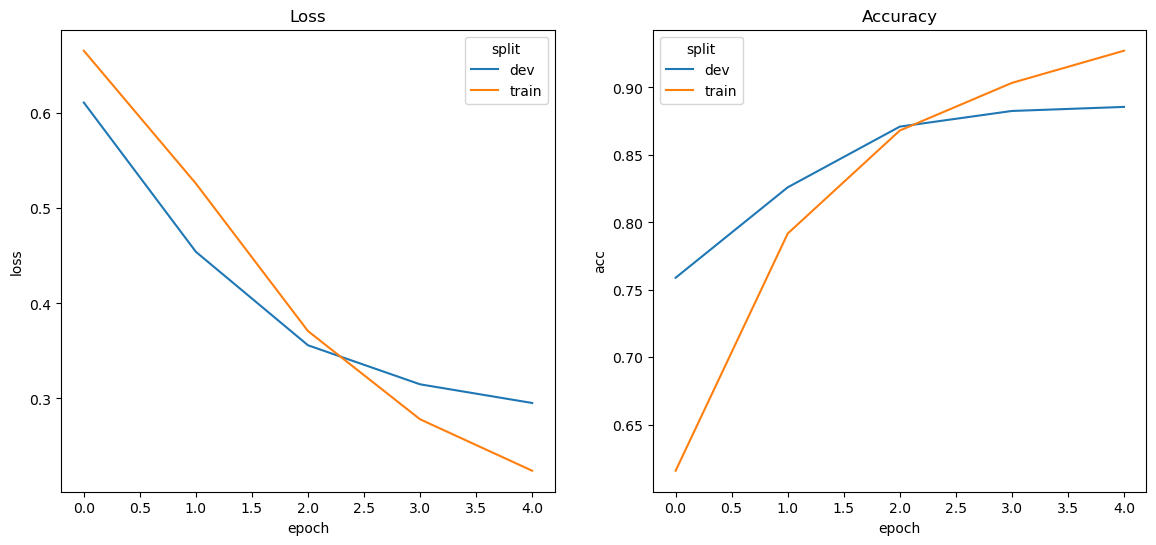

In [17]:
trainer.plot_history()

In [18]:
# see loss on test set
results = trainer.validate(test_loader, 'test', save_in_history=False)

Epoch 4 test loss: 0.3319, acc: 0.8628


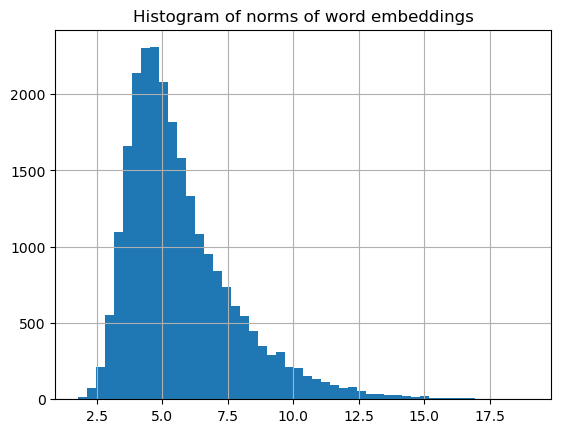

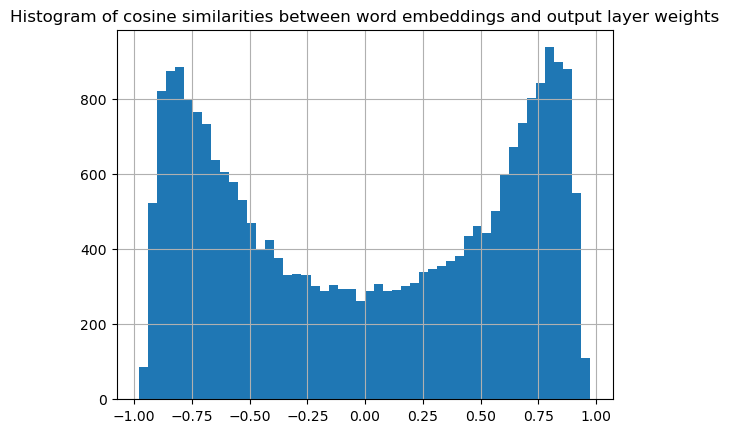

In [20]:
# visualize word embeddings learnt by this model
E = nbw_vanilla_model.embedding.weight.detach().cpu().numpy()
fc_vector = nbw_vanilla_model.fc.weight.detach().cpu().numpy().T

token_cossim_fc = dl_analysis.get_embedding_cosine_similarities(E, fc_vector)

# plot the histogram of norms of word embeddings
plt.hist(np.linalg.norm(E, axis=1), bins=50)
plt.title("Histogram of norms of word embeddings"); plt.grid(); plt.show()

# plot histogram of cosine similarities between word embeddings and the output layer weights
plt.hist(token_cossim_fc.flatten(), bins=50)
plt.title("Histogram of cosine similarities between word embeddings and output layer weights"); plt.grid(); plt.show()

# as expected, it splits words into positive and negative sentiment words
# though it probably overfit a little by associating specific words with sentiment too strongly
# without much evidence


In [21]:
frequent_local_ids = local_vocab.get_frequent_local_ids(10)
print (f"Out of {len(local_vocab)} tokens in train set, {len(frequent_local_ids)} tokens appear more than 10 times")

Out of 24692 tokens in train set, 16245 tokens appear more than 10 times


In [22]:
# show 10 random common tokens in each bucket of cosine similarity
print ("Random words in each bucket of cosine similarity with FC layer:")
for bucket in range(10):
    start = -1 + 2 * bucket / 10
    end = -1 + 2 * (bucket + 1) / 10
    print (f"{start:.2f} and {end:.2f}: ", end='')
    # indexes where cosine similarity is in the bucket
    indexes = np.where((token_cossim_fc >= start) & (token_cossim_fc < end))
    # indexes that are also in frequent_local_ids
    indexes = [idx for idx in indexes[0] if idx in frequent_local_ids]
    # show 10 random tokens
    np.random.seed(42)
    for idx in np.random.choice(indexes, 10):
        token = id_to_token.get(local_vocab.get_global_id_for_local_id(idx), '<UNK>')
        print (token, " ", end='')
    print()

Random words in each bucket of cosine similarity with FC layer:
-1.00 and -0.80: patent  convince  superficial  lois  declined  perez  cassie  filling  de  rangers  
-0.80 and -0.60: ##6  competent  ##rum  gunnar  belle  stamped  ##stic  bey  phillip  bite  
-0.60 and -0.40: immortality  stitch  baffled  expressing  mothers  breeding  package  ##end  ##using  ##zog  
-0.40 and -0.20: ##hill  ##ias  worm  hills  opens  jamie  cromwell  arms  wan  ##pr  
-0.20 and 0.00: consistently  celebrity  lauded  steadily  landed  newcomers  baghdad  going  shu  vera  
0.00 and 0.20: pain  suspicion  ##rts  bed  fires  cause  method  naval  ##iac  queen  
0.20 and 0.40: marshall  daniela  vault  dog  aimee  spirit  washington  policemen  measure  draft  
0.40 and 0.60: ##bm  busted  ##iente  digitally  ##fighter  pm  ni  professor  intimacy  boats  
0.60 and 0.80: timing  dorm  network  ##ence  immortal  ##bson  contrary  ##sey  locations  electric  
0.80 and 1.00: depression  italy  sympathetic  e

In [23]:
# model overfit a little but the final accuracy looks pretty good 0.88
# understand the examples where its failing / succeeding
# see confusion matrix

results_on_validation = trainer.validate(val_loader, 'val', save_in_history=False)

for i in range(len(results_on_validation)):
    data = results_on_validation[i]
    fc_similarity = token_cossim_fc[data['token_ids']]
    input_tokens = [id_to_token.get(local_vocab.get_global_id_for_local_id(id), '[UNK]') for id in data['token_ids']]
    data['input_tokens'] = input_tokens
    data['fc_similarity'] = fc_similarity

results_on_validation_df = pd.DataFrame(results_on_validation)
results_on_validation_df['prediction_label'] = results_on_validation_df['prediction'].apply(lambda x: 1 if x >= 0.5 else 0)

Epoch 4 val loss: 0.2953, acc: 0.8856


prediction_label     0     1
label                       
0.0               2272   222
1.0                350  2156


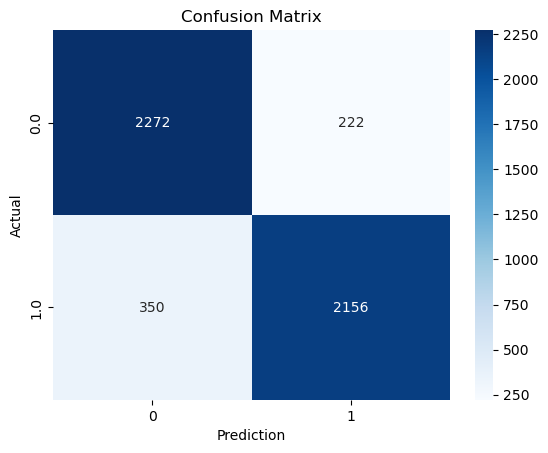

Examples where model is failing


Actual: 0.0, Prediction: 0.9796



Actual: 1.0, Prediction: 0.3482



Actual: 0.0, Prediction: 0.6083



Actual: 0.0, Prediction: 0.6932



Actual: 0.0, Prediction: 0.7488



Actual: 1.0, Prediction: 0.0016



Actual: 0.0, Prediction: 0.5037



Actual: 0.0, Prediction: 0.9299



Actual: 1.0, Prediction: 0.3543



Actual: 1.0, Prediction: 0.4721



Examples where model is succeeding


Actual: 1.0, Prediction: 0.5748



Actual: 0.0, Prediction: 0.0363



Actual: 1.0, Prediction: 0.8436



Actual: 0.0, Prediction: 0.0014



Actual: 0.0, Prediction: 0.0175



Actual: 0.0, Prediction: 0.1125



Actual: 1.0, Prediction: 0.9377



Actual: 0.0, Prediction: 0.0003



Actual: 0.0, Prediction: 0.0103



Actual: 0.0, Prediction: 0.0615



In [25]:
# confusion matrix
confusion_matrix = pd.crosstab(results_on_validation_df['label'], results_on_validation_df['prediction_label'])
print (confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues'); plt.xlabel('Prediction'); plt.ylabel('Actual'); plt.title('Confusion Matrix'); plt.show()

# see examples where model is failing or succeeding
print ("Examples where model is failing")
# shuffle the dataframe
pdf = results_on_validation_df.sample(frac=1, random_state=42)
negative_samples = pdf.query("label != prediction_label").head(10)
for i, row in negative_samples.iterrows():
    dl_analysis.display_colored_text(row['input_tokens'], row['fc_similarity'])
    print (f"Actual: {row['label']}, Prediction: {row['prediction']:.4f}\n")

print ("\n\nExamples where model is succeeding")
positive_samples = pdf.query("label == prediction_label").head(10)
for i, row in positive_samples.iterrows():
    dl_analysis.display_colored_text(row['input_tokens'], row['fc_similarity'])
    print (f"Actual: {row['label']}, Prediction: {row['prediction']:.4f}\n")

In [49]:
# model inferences on a few examples
# accuracy on the specific dataset is fine but it is not
# generalizing well to anything that varies slightly from original distribution
# it is assigning extremely low scores on even neutral words like "actor", "were"
# this is probably a quirk of this dataset that negative reviews are more likely to use these words

inference_reviews = [
    "This movie was the worst movie I have ever seen. The acting was terrible and the plot was boring.",
    "I loved the movie. The actors were great and the plot was entertaining.",
    "The movie was okay. The acting was good but the plot was boring.",
    "The movie was okay. The acting was horrible but the plot was interesting."
]

standardized_reviews = [custom_standardization(review) for review in inference_reviews]
tokenized_reviews = [tokenizer(review, padding='max_length', truncation=True, max_length=512) for review in standardized_reviews]
local_tokenized_reviews = [[local_vocab.get_local_id_for_global_id(id) for id in review['input_ids']] for review in tokenized_reviews]
local_tokenized_reviews = torch.tensor(local_tokenized_reviews, dtype=torch.long)


nbw_vanilla_model.eval()
with torch.no_grad():
    predictions = nbw_vanilla_model(local_tokenized_reviews.to('cuda')).cpu().numpy()

for i, review in enumerate(inference_reviews):
    # show colored text
    fc_similarity = token_cossim_fc[local_tokenized_reviews[i]]
    input_tokens = [id_to_token.get(id, '[UNK]') for id in tokenized_reviews[i]['input_ids']]
    dl_analysis.display_colored_text(input_tokens, fc_similarity)
    print (f"Prediction: {predictions[i][0]:.4f}\n\n")

Prediction: 0.1522




Prediction: 0.4919




Prediction: 0.2047




Prediction: 0.1654




In [70]:
# embedding size 1 should give the same results too since all we're doing is assigning a sentiment to each word
params = {
    'embedding_dim': 1,
    'drop_out': 0.5,
    'learning_rate': 0.01,
    'batch_size': 64
}

In [71]:
nbw_1d_model = nlp_models.NBWVanillaModel(len(local_vocab), params['embedding_dim'], dropout=(params['drop_out'], 0))
# set fc layer weights manually to have slope 1 and bias 0 and freeze them
nbw_1d_model.fc.weight.data = torch.tensor([[1.0]]).to('cuda')
nbw_1d_model.fc.bias.data = torch.tensor([0.0]).to('cuda')
nbw_1d_model.fc.weight.requires_grad = False
print (nbw_1d_model)

loss_function = nn.BCELoss()

trainer = nlp_training.TextClassificationTrainer(nbw_1d_model, loss_function, params)
train_loader = DataLoader(ReviewSentimentTorchDataset(imdb_train, local_vocab=local_vocab), batch_size=params['batch_size'], shuffle=True)

NBWVanillaModel(
  (embedding): Embedding(24692, 1)
  (dropout1): Dropout(p=0.5, inplace=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (dropout2): Dropout(p=0, inplace=False)
  (fc): Linear(in_features=1, out_features=1, bias=True)
)


In [72]:
trainer.train(train_loader, val_loader, 5)

Epoch 1/5 [Training]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 0 train loss: 0.6842, acc: 0.6083
Epoch 0 dev loss: 0.6733, acc: 0.7274


Epoch 2/5 [Training]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1 train loss: 0.6634, acc: 0.7304
Epoch 1 dev loss: 0.6546, acc: 0.7652


Epoch 3/5 [Training]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2 train loss: 0.6448, acc: 0.7531
Epoch 2 dev loss: 0.6384, acc: 0.7384


Epoch 4/5 [Training]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3 train loss: 0.6284, acc: 0.7655
Epoch 3 dev loss: 0.6229, acc: 0.7758


Epoch 5/5 [Training]:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4 train loss: 0.6131, acc: 0.7758
Epoch 4 dev loss: 0.6094, acc: 0.7928


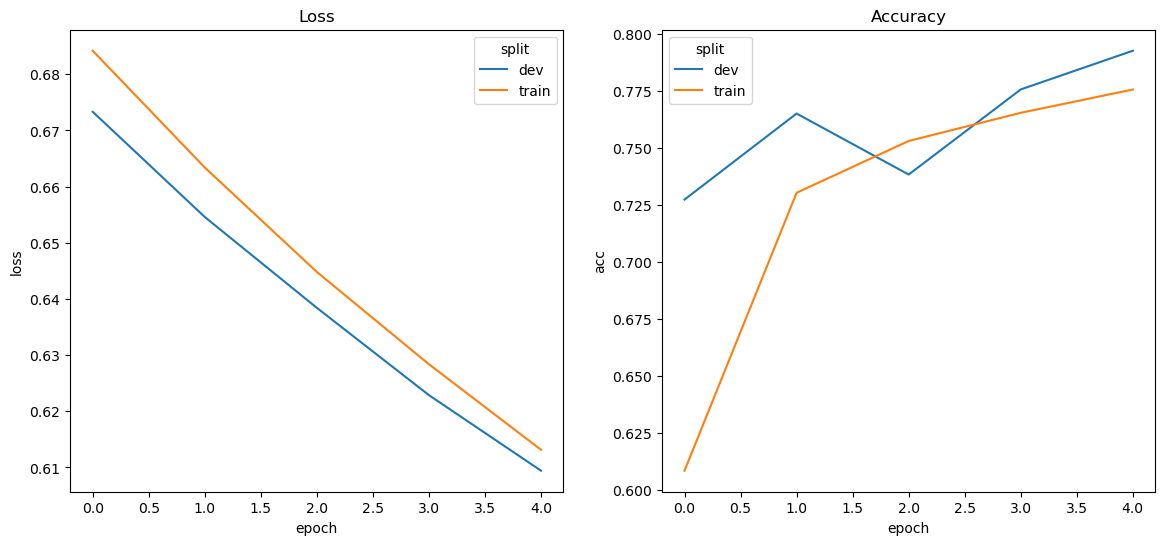

In [73]:
trainer.plot_history()

In [74]:
# see loss on test set
results = trainer.validate(test_loader, 'test', save_in_history=False)

Epoch 4 test loss: 0.6151, acc: 0.7802


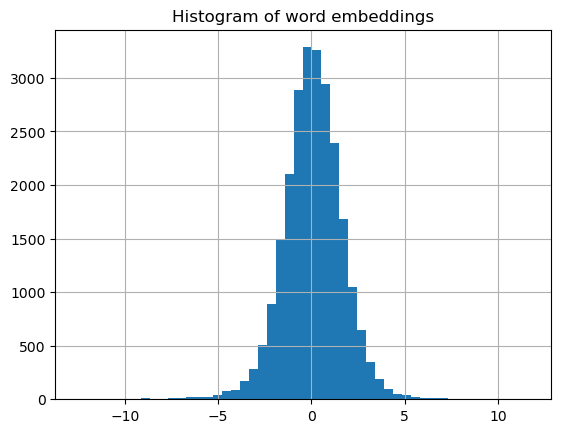

In [79]:
# visualize word embeddings learnt by this model
E = nbw_1d_model.embedding.weight.detach().cpu().numpy()

# plot histogram of E
plt.hist(E, bins=50)
plt.title("Histogram of word embeddings"); plt.grid(); plt.show()

In [80]:
# show 10 random common tokens in each bucket of embedding value
print ("Random words in each bucket of embedding value:")
for bucket in range(10):
    start = -5 + 10 * bucket / 10
    end = -5 + 10 * (bucket + 1) / 10
    print (f"{start:.2f} and {end:.2f}: ", end='')
    # indexes where cosine similarity is in the bucket
    indexes = np.where((E >= start) & (E < end))
    # indexes that are also in frequent_local_ids
    indexes = [idx for idx in indexes[0] if idx in frequent_local_ids]
    # show 10 random tokens
    np.random.seed(42)
    for idx in np.random.choice(indexes, 10):
        token = id_to_token.get(local_vocab.get_global_id_for_local_id(idx), '<UNK>')
        print (token, " ", end='')
    print()

Random words in each bucket of embedding value:
-5.00 and -4.00: werewolf  pseudo  so  ##tf  $  did  werewolf  ##cious  hate  shoot  
-4.00 and -3.00: opening  andrea  scientists  pile  doesn  useless  ##real  opening  neither  makers  
-3.00 and -2.00: else  kata  glowing  priest  exposition  dimensional  starters  ab  cows  meant  
-2.00 and -1.00: ##lon  ##ization  dread  ##rdi  opted  platform  ##lla  fisherman  ##zz  fishing  
-1.00 and 0.00: contra  bronx  alternate  amusement  introduce  revealed  irrational  babies  swearing  marines  
0.00 and 1.00: ##force  duly  ~  ##lian  python  ##hit  hosted  abroad  tonight  hawks  
1.00 and 2.00: prisoner  thomas  invade  rebellious  lighter  wyoming  ##ation  capitalism  ##eon  bourne  
2.00 and 3.00: manifest  newman  ting  melbourne  holly  request  martin  jackie  ##manship  established  
3.00 and 4.00: directs  rail  ##dal  guardian  royalty  catch  br  friends  directs  frank  
4.00 and 5.00: tear  novak  magnificent  ##wy  ##na  

In [81]:
results_on_validation = trainer.validate(val_loader, 'val', save_in_history=False)

for i in range(len(results_on_validation)):
    data = results_on_validation[i]
    fc_similarity = E[data['token_ids']]
    input_tokens = [id_to_token.get(local_vocab.get_global_id_for_local_id(id), '[UNK]') for id in data['token_ids']]
    data['input_tokens'] = input_tokens
    data['fc_similarity'] = fc_similarity

results_on_validation_df = pd.DataFrame(results_on_validation)
results_on_validation_df['prediction_label'] = results_on_validation_df['prediction'].apply(lambda x: 1 if x >= 0.5 else 0)

Epoch 4 val loss: 0.6094, acc: 0.7928


prediction_label     0     1
label                       
0.0               2135   359
1.0                677  1829


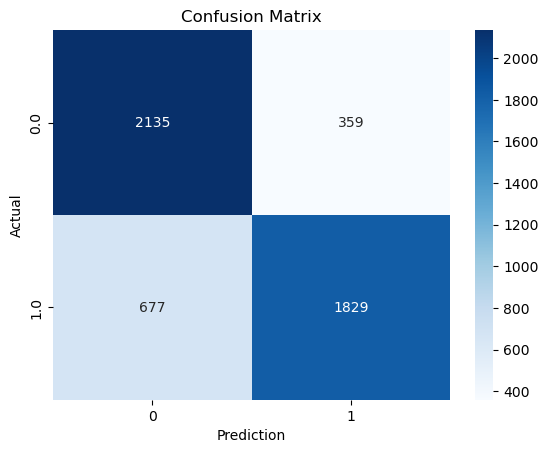

Examples where model is failing


Actual: 1.0, Prediction: 0.4937



Actual: 0.0, Prediction: 0.5291



Actual: 1.0, Prediction: 0.4725



Actual: 0.0, Prediction: 0.5024



Actual: 0.0, Prediction: 0.5340



Actual: 0.0, Prediction: 0.6174



Actual: 0.0, Prediction: 0.5407



Actual: 1.0, Prediction: 0.4933



Actual: 1.0, Prediction: 0.4285



Actual: 0.0, Prediction: 0.5118



Examples where model is succeeding


Actual: 1.0, Prediction: 0.5521



Actual: 0.0, Prediction: 0.3558



Actual: 1.0, Prediction: 0.5273



Actual: 0.0, Prediction: 0.3097



Actual: 0.0, Prediction: 0.4472



Actual: 0.0, Prediction: 0.4048



Actual: 0.0, Prediction: 0.2965



Actual: 0.0, Prediction: 0.3979



Actual: 0.0, Prediction: 0.4537



Actual: 1.0, Prediction: 0.5119



In [82]:
# confusion matrix
confusion_matrix = pd.crosstab(results_on_validation_df['label'], results_on_validation_df['prediction_label'])
print (confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues'); plt.xlabel('Prediction'); plt.ylabel('Actual'); plt.title('Confusion Matrix'); plt.show()

# see examples where model is failing or succeeding
print ("Examples where model is failing")
# shuffle the dataframe
pdf = results_on_validation_df.sample(frac=1, random_state=42)
negative_samples = pdf.query("label != prediction_label").head(10)
for i, row in negative_samples.iterrows():
    dl_analysis.display_colored_text(row['input_tokens'], row['fc_similarity'])
    print (f"Actual: {row['label']}, Prediction: {row['prediction']:.4f}\n")

print ("\n\nExamples where model is succeeding")
positive_samples = pdf.query("label == prediction_label").head(10)
for i, row in positive_samples.iterrows():
    dl_analysis.display_colored_text(row['input_tokens'], row['fc_similarity'])
    print (f"Actual: {row['label']}, Prediction: {row['prediction']:.4f}\n")

In [84]:
# similar results as before. It also can achieve ~80% accuracy
# the model underfit but it can probably tuned to achieve the same results as before

## BERT based models

## distillBERT-CLS-pretrained-static

Precompute static [CLS] token embeddings and train a simple logistic regression model on top of it

In [29]:
# create a hf dataset by collecting all CLS outputs for each review
def get_all_cls_embeddings(root_dir):
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.pkl'):
                batch = []
                with open(os.path.join(root, file), 'rb') as f:
                    batch = pickle.load(f)
                for data in batch:
                    row = {k: data[k] for k in ['split', 'text', 'label']}
                    row['cls_embedding'] = data['last_hidden_state'][0]
                    yield row

root_dir = 'local/distillBERT_inference_imdb_sentiment/'
cls_data = []
for subdir in tqdm(list(filter(lambda x: os.path.isdir(root_dir + x), os.listdir(root_dir))), desc="load cls data"):
    cls_data.append(datasets.Dataset.from_list(list(get_all_cls_embeddings(root_dir+subdir))))

cls_data = datasets.concatenate_datasets(cls_data)

load cls data:   0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
cls_train = cls_data.filter(lambda x: x['split'] == 'train')
cls_test = cls_data.filter(lambda x: x['split'] == 'test')
train_dev = cls_train.train_test_split(test_size=0.2, seed=42)
cls_train = train_dev['train']
cls_dev = train_dev['test']

print (len(cls_train), len(cls_dev), len(cls_test))
print (Counter(cls_train['label']), Counter(cls_dev['label']), Counter(cls_test['label']))

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

20000 5000 25000
Counter({1: 10028, 0: 9972}) Counter({0: 2528, 1: 2472}) Counter({0: 12500, 1: 12500})


In [44]:
# analyze embeddings
train_emb_matrix = np.array(list(cls_train['cls_embedding']))
print (train_emb_matrix.shape)

(20000, 768)


(20000,)


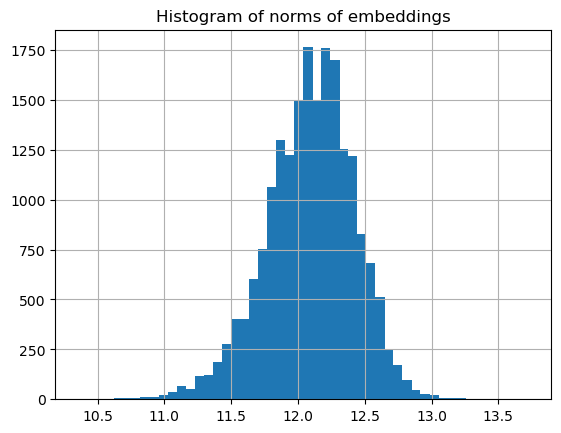

In [45]:
# plot histogram of norms of embeddings
norms = np.linalg.norm(train_emb_matrix, axis=1)
print (norms.shape)
plt.hist(norms, bins=50)
plt.title("Histogram of norms of embeddings"); plt.grid(); plt.show()

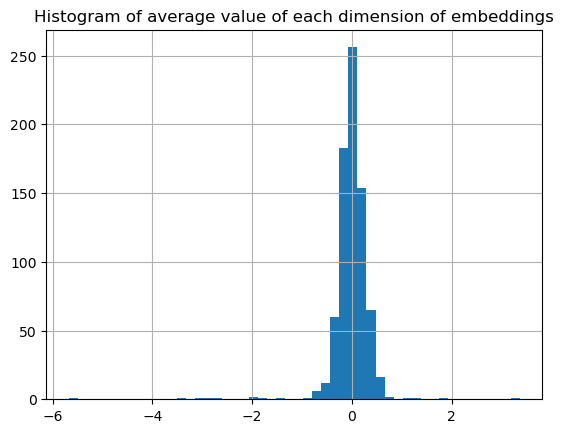

In [47]:
# plot histogram of average value of each dimension
plt.hist(np.mean(train_emb_matrix, axis=0), bins=50)
plt.title("Histogram of average value of each dimension of embeddings"); plt.grid(); plt.show()
# most dimensions have small values but some dimensions have big values

In [62]:
class CLS_EMB_ReviewSentimentTorchDataset(Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        data = self.hf_dataset[idx]
        review = torch.tensor(data['cls_embedding'], dtype=torch.float)
        sentiment = torch.tensor(data['label'], dtype=torch.float)
        return review, sentiment

cls_val_loader = DataLoader(CLS_EMB_ReviewSentimentTorchDataset(cls_dev), batch_size=5000)
cls_test_loader = DataLoader(CLS_EMB_ReviewSentimentTorchDataset(cls_test), batch_size=5000)

In [63]:
# hyper params
params = {
    'drop_out': 0.2,
    'learning_rate': 0.004,
    'batch_size': 100
}

In [66]:
cls_classifier = nlp_models.FF_CLS_Classifier(768, dropout=params['drop_out'])
loss_function = nn.BCELoss()

trainer = nlp_training.TextClassificationTrainer(cls_classifier, loss_function, params)
cls_train_loader = DataLoader(CLS_EMB_ReviewSentimentTorchDataset(cls_train), batch_size=params['batch_size'], shuffle=True)

In [68]:
trainer.train(cls_train_loader, cls_val_loader, 5)

Epoch 5/9 [Training]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4 train loss: 0.3647, acc: 0.8428
Epoch 4 dev loss: 0.3287, acc: 0.8624


Epoch 6/9 [Training]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5 train loss: 0.3578, acc: 0.8480
Epoch 5 dev loss: 0.3187, acc: 0.8636


Epoch 7/9 [Training]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6 train loss: 0.3621, acc: 0.8439
Epoch 6 dev loss: 0.3242, acc: 0.8628


Epoch 8/9 [Training]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7 train loss: 0.3620, acc: 0.8449
Epoch 7 dev loss: 0.3276, acc: 0.8640


Epoch 9/9 [Training]:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8 train loss: 0.3606, acc: 0.8458
Epoch 8 dev loss: 0.3357, acc: 0.8514


In [58]:
AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

- analyze clusters of contextual embeddings of tokens. Do they make sense?
- cluster reviews and see if they make sense
- simpe model that first projects token embeddings into a lower dimensional space and then averages and fc layer predicts sentiment
    - this allows us to see which words are negative / positive based on context